In [73]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from pyha import *
from pyha.cores import *
from pyha.cores.util import *
import scipy
from scipy import signal
import warnings
warnings.filterwarnings('ignore') # yolo!
import numpy as np
import inspect

# GitHub cannot display the Table of Contents!

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Info

In [3]:
print(inspect.getdoc(BitreversalFFTshiftAVGPool))
print('\n\nMain interface\n' + inspect.getdoc(BitreversalFFTshiftAVGPool.main))

Bitreversal, FFTShift and AveragePooling
----------------------------------------

Fixes bitreversal, performs fftshift and applies average pooling, implemented with 2 BRAM blocks.
Internal accumulator may overflow, in which case it is saturated.

Args:
    fft_size:
    avg_freq_axis: Pooling in frequnecy domain, decimates the data rate and has major impact on resource usage.
        Large decimations use LESS memory.
        Example, if input is 1024 point fft and avg_freq_axis is 2, then output is 512 points.
    avg_time_axis: Pooling in time domain, decimates the data rate.

TODO: this core should be unsigned...


Main interface
Args:
    input (DataValid): 36 bits, type not restricted

Returns:
    DataValid: Output type shifted right by the bit-growth.


# Examples

## Fix bitreversal and fftshift

INFO:sim:Tracing is enabled, running "MODEL" and "HARDWARE" simulations
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "HARDWARE" simulation...


100%|██████████| 262144/262144 [00:14<00:00, 18234.23it/s]

INFO:sim:Flushing the pipeline to collect 131072 valid samples (currently have 130816)
INFO:sim:Flush took 258 cycles.
INFO:sim:OK!
INFO:sim:Simulations completed!


<IPython.core.display.Javascript object>


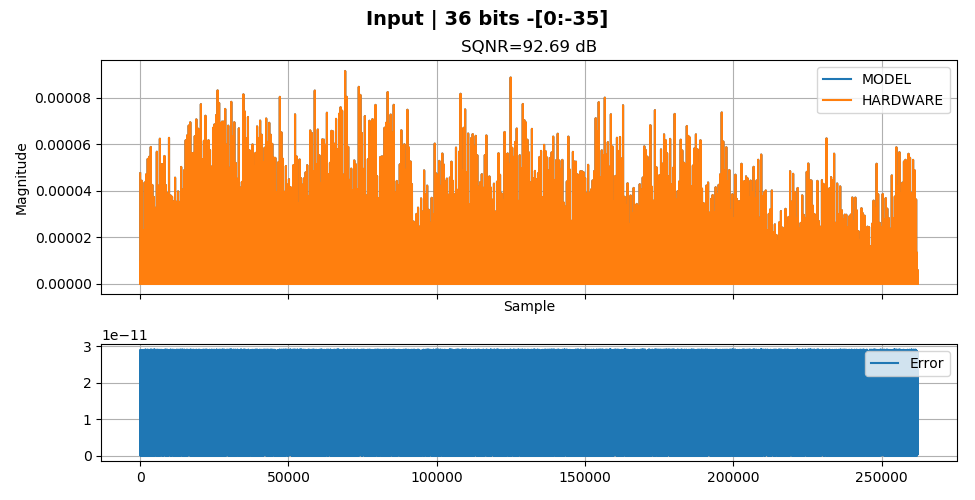

<IPython.core.display.Javascript object>


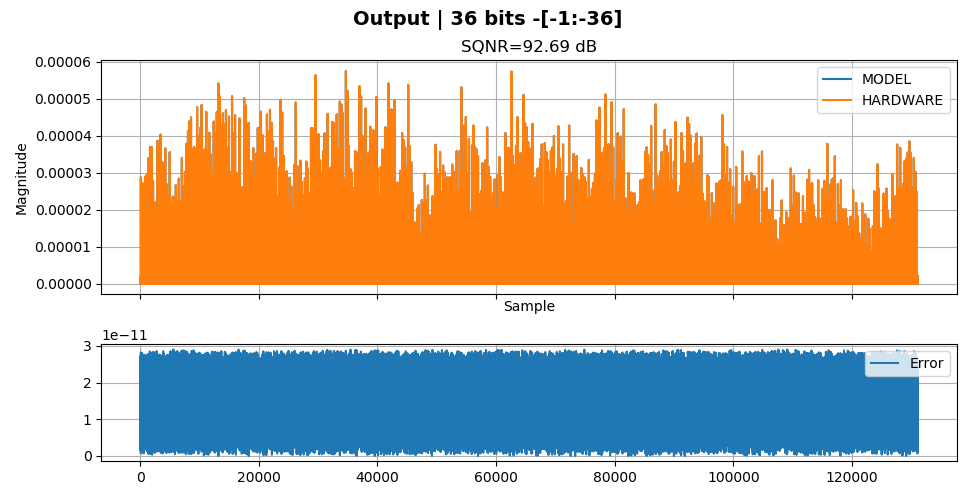

<IPython.core.display.Javascript object>


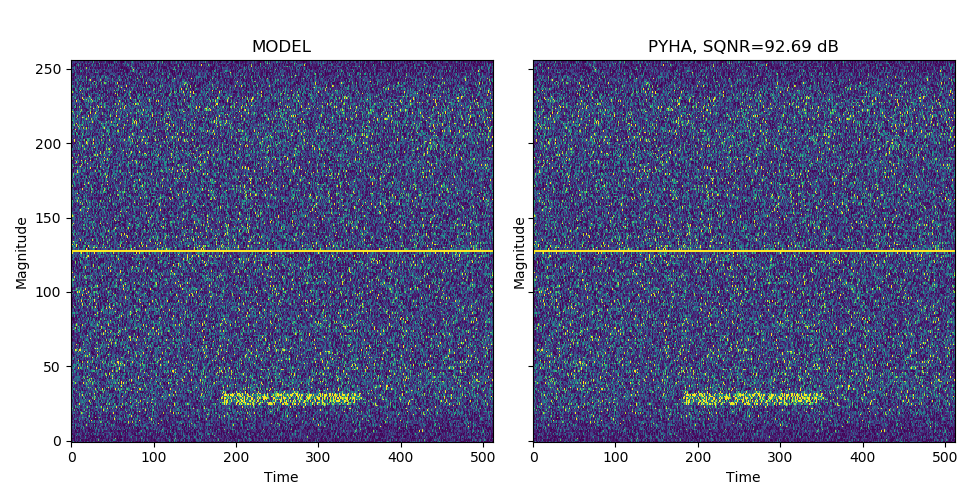

In [4]:
file = get_data_file('limem_ph3weak_40m')
input_signal = load_complex64_file(file)

fft_size = 512
_, _, spectro_out = signal.spectrogram(input_signal, 1, nperseg=fft_size, return_onesided=False, detrend=False,
                               noverlap=0, window='hann')
spectro_out = toggle_bit_reverse(spectro_out.T) # apply hardware impairments
spectro_out = spectro_out.flatten()

dut = BitreversalFFTshiftAVGPool(fft_size, avg_freq_axis=2, avg_time_axis=1)
sims = simulate(dut, spectro_out, trace=True, pipeline_flush='auto') # run simulations and gather trace
plot_trace()
plot_imshow(sims, rows=dut.FFT_SIZE // dut.AVG_FREQ_AXIS, transpose=True)

## Pool `avg_freq_axis = 8` and `avg_time_axis=16`

INFO:sim:Tracing is enabled, running "MODEL" and "HARDWARE" simulations
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "HARDWARE" simulation...


100%|██████████| 262144/262144 [00:15<00:00, 16677.00it/s]

INFO:sim:Flushing the pipeline to collect 2048 valid samples (currently have 1984)
INFO:sim:Flush took 66 cycles.
INFO:sim:OK!
INFO:sim:Simulations completed!


<IPython.core.display.Javascript object>


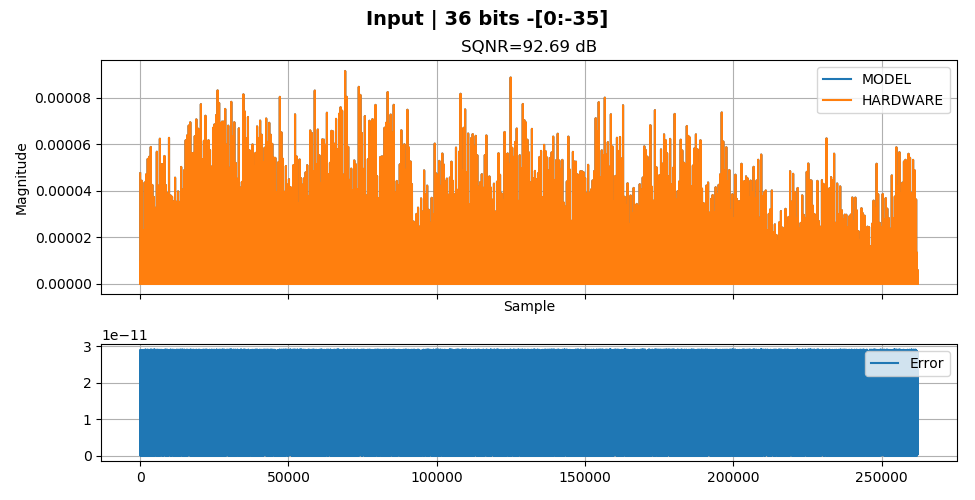

<IPython.core.display.Javascript object>


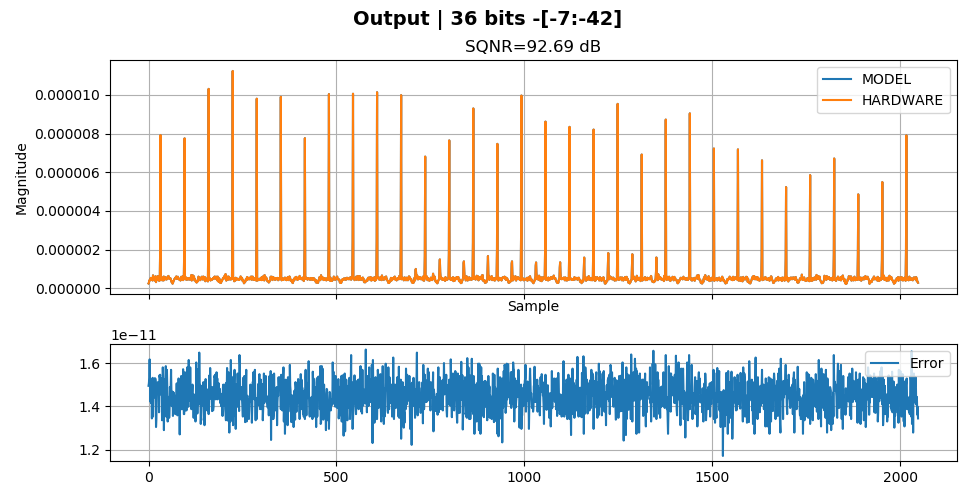

<IPython.core.display.Javascript object>


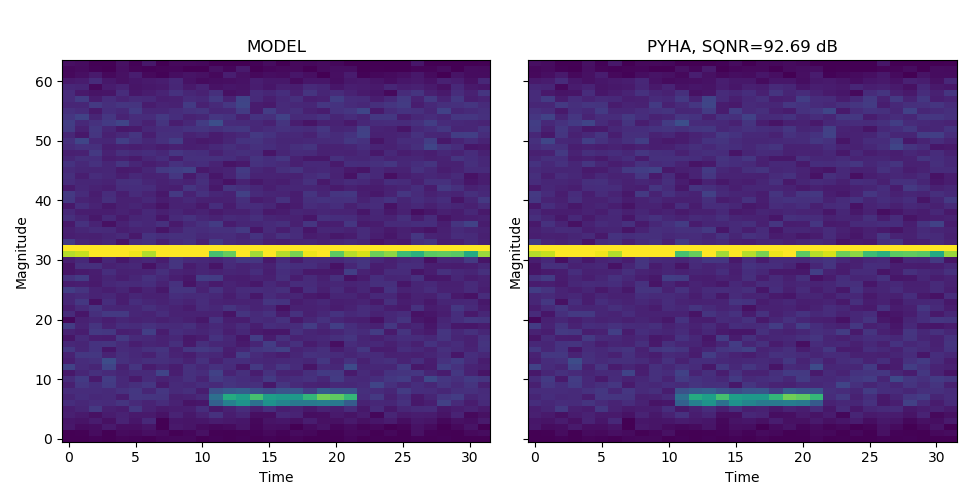

In [5]:
avg_time_axis = 16
dut = BitreversalFFTshiftAVGPool(fft_size, avg_freq_axis=8, avg_time_axis=avg_time_axis)
sims = simulate(dut, spectro_out, trace=True, pipeline_flush='auto') # run simulations and gather trace
plot_trace()
plot_imshow(sims, rows=dut.FFT_SIZE // dut.AVG_FREQ_AXIS, transpose=True)

# Conversion to VHDL and RTL/NETLIST simulations

In [17]:
# Pyha supports running 'RTL' (using GHDL) and 'NETLIST' (netlist after quartus_map) level simulations.
avg_time_axis = 4
fft_size = 512
input_signal = np.random.normal(size=fft_size * avg_time_axis) * 0.025
dut = BitreversalFFTshiftAVGPool(fft_size=fft_size, avg_freq_axis=8, avg_time_axis=avg_time_axis)
sims = simulate(dut, input_signal, pipeline_flush='auto', 
                simulations=['MODEL', 'HARDWARE', 'RTL', 'NETLIST'], 
                conversion_path='/tmp/pyha_output')
assert hardware_sims_equal(sims)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Simulaton needs to support conversion to VHDL -> major slowdown
INFO:sim:Running "HARDWARE" simulation...


100%|██████████| 2048/2048 [00:00<00:00, 2948.49it/s]

INFO:sim:Flushing the pipeline to collect 64 valid samples (currently have 0)


INFO:sim:Flush took 66 cycles.
INFO:sim:OK!
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:RAM to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:BitreversalFFTshiftAVGPool to VHDL ...
INFO:conversion:Took 0.62 seconds
INFO:sim:Running "RTL" simulation...
loading VPI module '/cocotb/build/libs/x86_64/libvpi.so'
VPI module loaded!
100%|##########| 2114/2114 [00:00<00:00, 5998.44it/s]

INFO:sim:OK!
INFO:sim:Running "NETLIST" simulation...
INFO:synth:Running quartus_map quartus_project...
INFO:synth:Running quartus_eda quartus_project...
loading VPI module '/cocotb/build/libs/x86_64/libvpi.so'
VPI module loaded!
100%|##########| 2114/2114 [00:16<00:00, 129.04it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:Testing hardware simulations equality...
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "HARDWARE" as golden output
INFO:sim

# Synthesis:  resource usage and Fmax

In [18]:
quartus = get_simulator_quartus() # reuse the work that was done during the simulation
print(quartus.get_resource_usage('fit'))
print(quartus.get_fmax())

INFO:synth:Running quartus_fit quartus_project...
INFO:synth:Running quartus_sta -t script.tcl...


Family : Cyclone IV E
Device : EP4CE40F23C8
Timing Models : Final
Total logic elements : 393 / 39,600 ( < 1 % )
    Total combinational functions : 390 / 39,600 ( < 1 % )
    Dedicated logic registers : 187 / 39,600 ( < 1 % )
Total registers : 187
Total pins : 76 / 329 ( 23 % )
Total virtual pins : 0
Total memory bits : 4,608 / 1,161,216 ( < 1 % )
Embedded Multiplier 9-bit elements : 0 / 232 ( 0 % )
Total PLLs : 0 / 4 ( 0 % )

+-------------------------------------------------+
; Fmax Summary                                    ;
+-----------+-----------------+------------+------+
; Fmax      ; Restricted Fmax ; Clock Name ; Note ;
+-----------+-----------------+------------+------+
; 86.27 MHz ; 86.27 MHz       ; clk        ;      ;
+-----------+-----------------+------------+------+
This panel reports FMAX for every clock in the design, regardless of the user-specified clock periods.  FMAX is only computed for paths where the source and destination registers or ports are driven by the